In this notebook I create a Type 1 recommendation system which is content-based using Natural Language Processing (NLP) and cosine similarity to find and recommend movies.
The dataset is available at:
https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies/data

In [ ]:
import numpy as np
import pandas as pd
import ast

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer


In [ ]:
# Load datasets
titles = pd.read_csv('/kaggle/input/netflix-tv-shows-and-movies/titles.csv')
credits = pd.read_csv('/kaggle/input/netflix-tv-shows-and-movies/credits.csv')



# Applying EDA

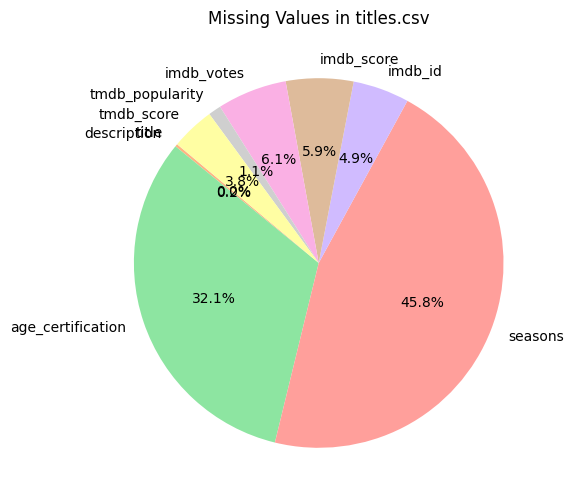

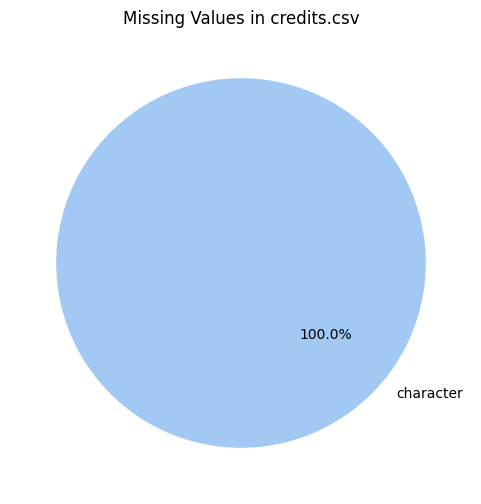

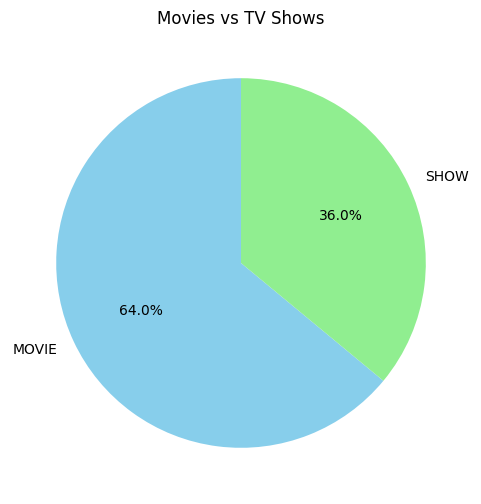

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


missing_titles = titles.isnull().sum()
missing_credits = credits.isnull().sum()

missing_titles_total = missing_titles[missing_titles > 0]
if not missing_titles_total.empty:
    plt.figure(figsize=(6,6))
    plt.pie(missing_titles_total, labels=missing_titles_total.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title("Missing Values in titles.csv")
    plt.show()

# Credits missing values pie chart
missing_credits_total = missing_credits[missing_credits > 0]
if not missing_credits_total.empty:
    plt.figure(figsize=(6,6))
    plt.pie(missing_credits_total, labels=missing_credits_total.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title("Missing Values in credits.csv")
    plt.show()


titles.columns = titles.columns.str.strip().str.lower()

type_counts = titles['type'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title("Movies vs TV Shows")
plt.show()




#  1)processing data

# a)handling with missing data text

In [ ]:
text_cols_titles = [
    'description',
    'genres',
    'production_countries',

]

for col in text_cols_titles:
    titles[col] = titles[col].fillna('unknown')

credits['character'] = credits['character'].fillna('unknown')

In [ ]:
#  Separate actors and directors
actors = credits[credits['role'] == 'ACTOR']
directors = credits[credits['role'] == 'DIRECTOR']

#  Aggregate actors & directors per title
actors_grouped = (
    actors.groupby('id')['name']
    .apply(lambda x: ' '.join(x))
    .reset_index()
    .rename(columns={'name': 'actors'})
)

directors_grouped = (
    directors.groupby('id')['name']
    .apply(lambda x: ' '.join(x))
    .reset_index()
    .rename(columns={'name': 'directors'})
)

#  Merge with titles
data = titles.merge(actors_grouped, on='id', how='left')
data = data.merge(directors_grouped, on='id', how='left')

# Fill missing merged text
data['actors'] = data['actors'].fillna('unknown')
data['directors'] = data['directors'].fillna('unknown')


In [ ]:
#  Create CONTENT column
data['content'] = (
    data['description'] + ' ' +
    data['genres'] + ' ' +
    data['production_countries'] + ' ' +
    data['actors'] + ' ' +
    data['directors']
)

In [ ]:
from IPython.display import display

print("Dataset shape:", data.shape)

display(
    data[['title', 'content']].head(5)
)


Dataset shape: (5850, 18)


,title,content
0,Five Came Back: The Reference Films,This collection includes 12 World War II-era p...
1,Taxi Driver,A mentally unstable Vietnam War veteran works ...
2,Deliverance,Intent on seeing the Cahulawassee River before...
3,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui..."
4,The Dirty Dozen,12 American military prisoners in World War II...


# b) applying lower case and tokinization ,vectorization TF_IDF

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing
data['content_processed'] = data['content'].apply(lambda x: x.lower())

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['content_processed'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),

    columns=tfidf.get_feature_names_out(),
    index=data['title']
)

display(tfidf_df.head())


TF-IDF matrix shape: (5850, 59593)


,00,000,0001,007,0093,0096,05,10,100,1001,...,麻婆斗妇,박소연,블레어,시몬스,오승열,장성,정지환,주둥닝,지뢰,탕빈
title,,,,,,,,,,,,,,,,,,,,,
Five Came Back: The Reference Films,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Taxi Driver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Deliverance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Monty Python and the Holy Grail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Dirty Dozen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#  c )handling with missing data numerique  with standarisation using median

In [ ]:
numeric_cols = [
    'runtime',
    'seasons',
    'imdb_score',
    'imdb_votes',
    'tmdb_score',
    'tmdb_popularity'
]

for col in numeric_cols:
    data[col] = data[col].fillna(data[col].median())


# 3 )Compute Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


# 4) Create Recommendation Function   

    Given a movie title, return top_k similar movies


In [ ]:
def recommend(title, data=data, cosine_sim=cosine_sim, top_k=5):

    #  Find the movie index
    idx = data[data['title'] == title].index
    if len(idx) == 0:
        return "Movie not found"
    idx = idx[0]

    #  Get similarity scores for all movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    #  Sort by similarity score (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:top_k+1]

    movie_indices = [i[0] for i in sim_scores]

    #  Return recommended movies
    return data[['title', 'imdb_score', 'tmdb_popularity']].iloc[movie_indices]


# 5 Test the Recommendation System

In [ ]:
recommendations = recommend("Stranger Things")
display(recommendations)


,title,imdb_score,tmdb_popularity
3435,Prank Encounters,5.2,15.251
4788,Inside Job,7.6,42.395
3295,Eli,5.8,31.780
4963,Fear Street: 1666,6.6,89.695
2553,Trevor Noah: Afraid of the Dark,7.2,4.794
